<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import nltk
import re

from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot
from keras.models import Model
import keras.backend as K

from gensim.models import FastText
from gensim.test.utils import common_corpus

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [7]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
len(thurs)

320525

In [20]:
thurs = thurs.split('\n\n')
len(thurs)

1304

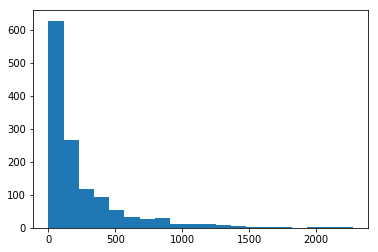

In [24]:
plt.hist([len(d) for d in thurs], bins=20)
plt.show()

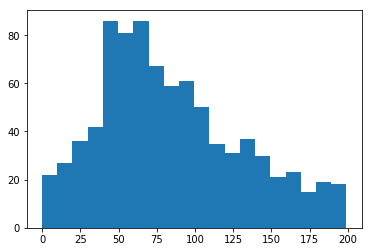

In [31]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=20)
plt.show()

In [34]:
len([d for d in thurs if len(d)>75])

876

In [0]:
thurs = [d for d in thurs if len(d)>75]

In [0]:
thurs = [' '.join(d.split()) for d in thurs]

In [38]:
thurs[10]

'"Nonsense!" said Gregory, who was very rational when anyone else attempted paradox. "Why do all the clerks and navvies in the railway trains look so sad and tired, so very sad and tired? I will tell you. It is because they know that the train is going right. It is because they know that whatever place they have taken a ticket for that place they will reach. It is because after they have passed Sloane Square they know that the next station must be Victoria, and nothing but Victoria. Oh, their wild rapture! oh, their eyes like stars and their souls again in Eden, if the next station were unaccountably Baker Street!"'

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TopicalLanguageModel:
  """
  Neural Topical Language Model.
  """
  def __init__(self, num_topics, word_embedding, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz ', batch_size=20):
    self.num_topics = num_topics
    self.word_embedding = word_embedding
    self.lm_length = lm_length
    self.batch_size = batch_size

    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))]
    self.token2idx = {t:k for k,t in token_idx}
    self.idx2token = {k:t for k,t in token_idx}

    self.num_tokens = len(tokens)+3

  def generate_train_data(self, documents, batch_size=20): #fix documents inconsistency (list of document strings or list of list of words)
    while True:
      docs = np.random.choice(documents, size=batch_size)
      finish_idxs = [np.random.randint(0, len(d)+1) for d in documents]
      
      emb = lambda x: self.word_embedding.get(x, np.zeros(self.word_embedding.vector_size))
      x_topic = np.array([np.array([emb(w) for w in d]).mean(axis=0) for d in docs])

      joined_docs = [' '.join(d) for d in docs]
      joined_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, joined_docs)]
      x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in joined_docs])

      y = [self.token2idx[d[i]] if i != len(d) else 1 for i,d in zip(start_idxs, joined_docs)]

      yield [x_topic, x_lm], y

  def fit(self, documents, batch_size=20, epochs=10, verbose=0):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.word_embedding.vector_size,))
    h_topic = Dense(self.word_embedding.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens)(h_lm)
      out_lm = Dense(self.num_tokens, activation='softmax')(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.word_embedding.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=2)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(2, 1))([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=out)
    self.train_model.compile('adam', 'sparse_categorical_crossentropy')

    self.train_hist = self.train_model.fit_generator(self.generate_train_data(documents, batch_size=batch_size), 
                                                     steps_per_epoch=len(documents)//batch_size, 
                                                     epochs=epochs)

  def predict(self, init_doc, topic, method='sample'):
    pad_doc = ['<start>']*(self.window-1) + init_doc
    key = ' '.join(pad_doc[-self.window+1:])
    if method == 'sample':
      return np.random.choice([w for w,p in self.ngram_probs[topic][key]],
                              p=[p for w,p in self.ngram_probs[topic][key]])
    elif method == 'max':
      return self.ngram_probs[topic][key][np.argmax([p for w,p in self.ngram_probs[topic][key]])][0]

    elif method == 'distribution':
      return self.ngram_probs[topic][key]

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '<end>': break
      init_doc.append(predicted)

    return init_doc

  def get_topics(self, doc):
    cleaned = self.clean([doc])[0]
    bow = self.topic_model.id2word.doc2bow(cleaned)
    return [dict(self.topic_model[bow]).get(k,0) for k in range(self.num_topics)]

In [0]:
a = [0,1,2,3,4]
a[2:4]

[2, 3]

In [0]:
K.clear_session()

a = Input(shape=(2,3))
b = Input(shape=(3,))
c = Dot(axes=(2,1))([a,b])

mdl = Model(inputs=[a, b], outputs=c)

In [0]:
a = np.random.randn(1,2,3)
b = np.array([[1,1,-1]])
a, mdl.predict([a,b])

(array([[[-0.70201563, -1.36185487, -1.35750768],
         [-1.0031747 , -0.02161372,  0.03331503]]]),
 array([[-0.7063627, -1.0581034]], dtype=float32))